<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/HeatWaves_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Look at hourly temperature data over the part of the England . 
Can we say that the strength of heat waves increase over time?

We will build some geospatial models, using various Python frameworks (statsmodels, GPFlow, PyMC3) and use them for hypotheses testing.

Note: Heat is understood as the daily maximum temperature above the 95-percentile 
of the historical distribution for the location of interest. The heat wave is when at the given location we experience heat days in row.



## Read Data

We use netCDF4 library to handle the files. Inspecting the content we find the 3-dimensional temperature tensor, stored for the grid of 13x13 coordinates and over the time dimension. The coordinate grid is centered at around 51 degrees north and 0 degrees, likely at *London*.

In [ ]:
#@title

import netCDF4 as nc
import numpy as np
import pandas as pd

# read data
ds = nc.Dataset('/content/drive/MyDrive/Statistical Scientist Technical Challenge/raw_temp_data_london.nc',mode='r',format='NETCDF')
print(ds.variables.keys())#['VAR_2T']
print(ds.variables['VAR_2T'])
print(ds.variables['time'])
print('latitude pos:',ds.variables['latitude'],ds.variables['latitude'][:])
print('longitude pos:',ds.variables['longitude'],ds.variables['longitude'][:])

dict_keys(['VAR_2T', 'latitude', 'longitude', 'time'])
<class 'netCDF4._netCDF4.Variable'>
float32 VAR_2T(time, latitude, longitude)
    _FillValue: 9.999e+20
    long_name: 2 metre temperature
    short_name: 2t
    units: K
    original_format: WMO GRIB 1 with ECMWF local table
    ecmwf_local_table: 128
    ecmwf_parameter: 167
    minimum_value: 210.44434
    maximum_value: 321.4988
    grid_specification: 0.25 degree x 0.25 degree from 90N to 90S and 0E to 359.75E (721 x 1440 Latitude/Longitude)
    rda_dataset: ds633.0
    rda_dataset_url: https:/rda.ucar.edu/datasets/ds633.0/
    rda_dataset_doi: DOI: 10.5065/BH6N-5N20
    rda_dataset_group: ERA5 atmospheric surface analysis [netCDF4]
    number_of_significant_digits: 7
    missing_value: 9.999e+20
unlimited dimensions: 
current shape = (356448, 13, 13)
filling on
<class 'netCDF4._netCDF4.Variable'>
int64 time(time)
    long_name: time
    units: hours since 1979-01-01
    calendar: proleptic_gregorian
unlimited dimensions: 
cur

## Data Preprocessing

In addition to missing values, indicated by the mask and the special fill value, the data are *partly corrupted* with temperatures of thousands degrees. These values are to be ignored.

We use masked arrays to read the data, and multiindexed series to store.

The temperature data is presented *in degrees Celsius*.

In [ ]:
#@title

X = ds.variables['VAR_2T'][:]

# handle missing and corrupted values
print('missing data (%):',X.mask.mean().round(4))
mask = (X.data<210) | (X.data>321) & (X.data < 9.999e+20)
print('out-of-range data (%):', mask.mean().round(4))
print('wrong values:',X.data[mask])
mask = X.mask | (X.data<210) | (X.data>322)
print('all masked data (%):', mask.mean().round(4))

# make the data frame
index = pd.MultiIndex.from_product(map(range,X.shape),names=['time','lat','long'])
X = pd.Series(data=X.ravel()-273.15,index=index,dtype=np.float64,name='Temperature')
X[mask.flatten()] = np.nan
X.index.set_levels(pd.Timestamp('1979-01-01')+pd.to_timedelta(X.index.levels[0],unit='hours'),level='time',inplace=True)
X.index.set_levels(ds.variables['latitude'][:],level='lat',inplace=True)
X.index.set_levels(ds.variables['longitude'][:],level='long',inplace=True)
X

missing data (%): 0.0124
out-of-range data (%): 0.0001
wrong values: [2719.5454 2720.0532 2719.1938 ... 2739.762  2734.2346 2718.512 ]
all masked data (%): 0.0125


time                 lat   long 
1979-01-01 00:00:00  53.0  -1.50    -6.877045
                           -1.25    -6.347748
                           -1.00    -5.849701
                           -0.75    -5.214935
                           -0.50    -4.693451
                                      ...    
2019-08-30 23:00:00  50.0   0.50    18.135956
                            0.75    17.854706
                            1.00    17.331268
                            1.25    17.032440
                            1.50    16.454315
Name: Temperature, Length: 60239712, dtype: float64

## Explanatory Analysis

Look at the average monthly temperatures, and the temperature distributions over locations.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


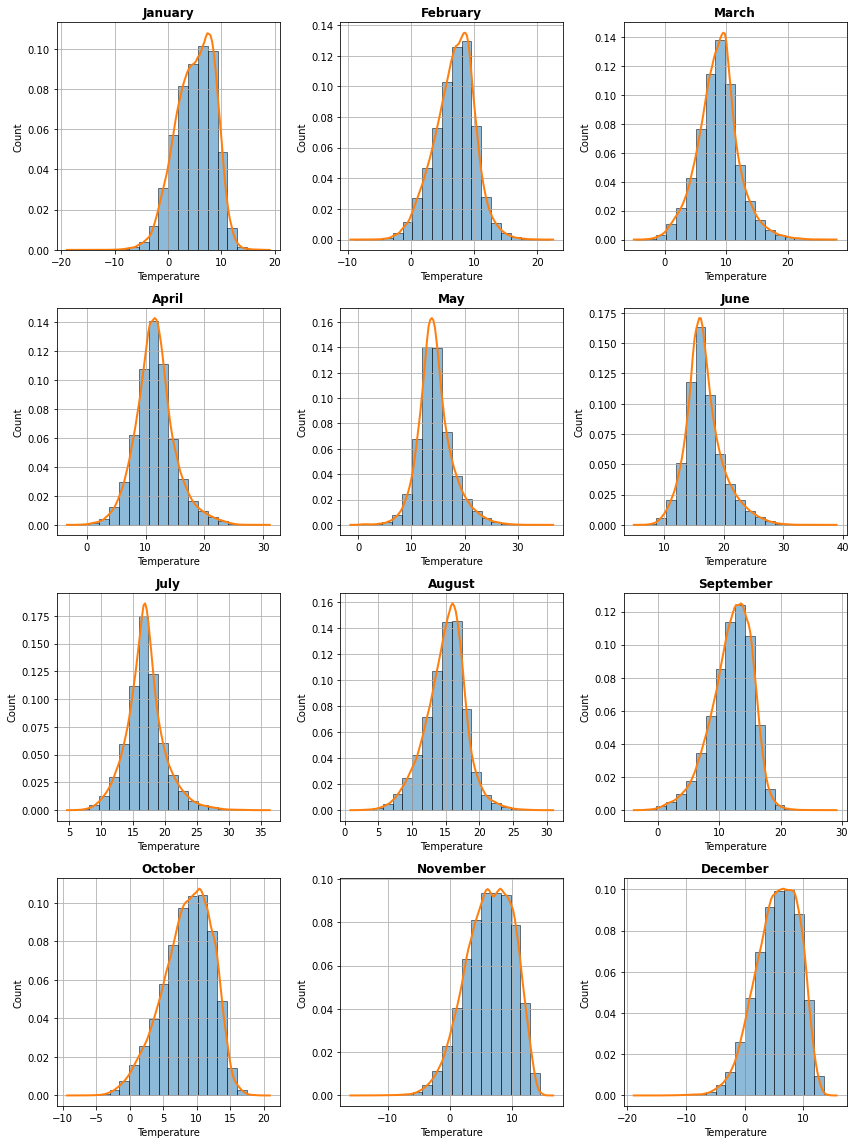

time
1      5.105391
2      6.883157
3      8.672328
4     11.605537
5     14.451566
6     16.769299
7     16.911814
8     14.969231
9     12.024682
10     8.583519
11     6.308807
12     5.525273
Name: Temperature, dtype: float64

In [ ]:
#@title 

ix = X.index.get_level_values('time').month

import calendar
from statsmodels.nonparametric.kde import KDEUnivariate 
from matplotlib import pyplot as plt

fig,axs = plt.subplots(4,3,figsize=(12, 16))
for i,ax in zip(ix.unique().to_list(),axs.ravel()):
  data = X[ix==i]
  kde = KDEUnivariate(X[ix==i])
  kde.fit(gridsize=100)
  ax.set_title(i)
  ax.set_title(calendar.month_name[i],fontdict={'fontweight':'bold'})
  ax.set(xlabel='Temperature',ylabel='Count')
  ax.hist(data, bins=20, density=True, edgecolor='k', alpha=0.5)
  ax.plot(kde.support, kde.density, lw=2)
  ax.grid(True, zorder=5)
plt.tight_layout()
plt.show()


X.groupby(ix).mean()

## Feature Engineering

We reduce the temperature to daily maximas (per location and date); then, given location, we find segments that exceed the 0.95-percentile. 

To this end, we leverage an efficient algorithm for finding *longest runs* of a given element in data stream.

In [ ]:
#@title Daily Max

dates = pd.to_datetime(X.index.get_level_values('time').date)
X = X.groupby(['lat','long',dates]).max()
X.index.names = ['lat','long','date']

In [ ]:
#@title Extreme Thresholds

t95 = dict(X.groupby(['lat','long']).quantile(0.95))
heat = X>X.index.map(lambda r: t95.get(r[:2]))

In [ ]:
#@title Algorithm for Longest Runs

import itertools

def longest_run(data,elem=1):
  ''' computes the longest run of an element in data (max block repeating the value) '''
  data = iter(data)
  data = itertools.groupby(data)
  data = filter(lambda t: t[0]==elem, data)
  data = map(lambda t: sum(1 for _ in t[1]),data)
  data = itertools.chain([0],data)
  return max(data)

L = [0,0,1,1,1,1,0,0,1,1,1,1,1,0,1,0]
assert longest_run(L,1) == 5
assert longest_run(L,2) == 0

In [ ]:
#@title Longest Heat Waves

heat.sort_index(level='date',ascending=True,inplace=True)
dates = heat.index.get_level_values('date').year
heat_wave = heat.astype(np.float32).groupby(['lat','long',dates]).apply(longest_run)
heat_wave.name = 'max_heat_wave'

## Visualize

,mean,std,max
date,,,
1979,2.153846,0.794325,3.0
1980,1.692308,0.566947,3.0
1981,2.852071,0.678329,5.0
1982,4.301775,1.396444,7.0
1983,7.153846,3.280534,13.0
1984,5.201183,1.518065,8.0
1985,1.887574,0.601901,4.0
1986,3.704142,2.134199,9.0
1987,2.810651,0.865822,8.0


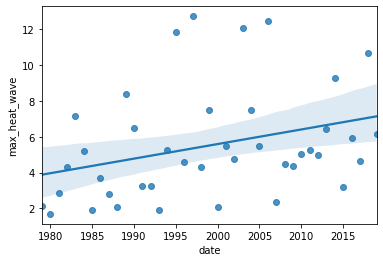

In [ ]:
#@title Longest heat waves by year

import seaborn as sns

heat_wave_year = heat_wave.groupby('date').mean()
sns.regplot(x=heat_wave_year.index,y=heat_wave_year,label='average heat wave [days]')
cols = ['mean','std','max']
heat_wave.groupby('date').describe()[cols]

In [ ]:
#@title Longest heat waves by location
pd.set_option('display.max_rows', 200)
cols = ['mean','std','max']
heat_wave.groupby(['lat','long']).describe()[cols]

mean       std   max
lat   long                           
50.00 -1.50  5.048780  3.506788  16.0
      -1.25  5.121951  3.994966  21.0
      -1.00  5.073171  4.008680  21.0
      -0.75  4.804878  3.363179  16.0
      -0.50  4.756098  3.396914  16.0
      -0.25  4.707317  3.487434  16.0
       0.00  4.682927  3.274439  16.0
       0.25  4.634146  3.047590  16.0
       0.50  4.609756  2.965451  16.0
       0.75  4.341463  2.744173  15.0
       1.00  4.560976  2.932991  17.0
       1.25  4.585366  2.991451  17.0
       1.50  4.780488  2.806352  14.0
50.25 -1.50  5.000000  3.801316  17.0
      -1.25  5.170732  4.253836  21.0
      -1.00  5.268293  4.213220  21.0
      -0.75  5.073171  4.227235  20.0
      -0.50  5.000000  4.055860  20.0
      -0.25  5.073171  4.095059  20.0
       0.00  4.975610  4.052702  20.0
       0.25  5.121951  3.982431  19.0
       0.50  5.073171  3.888382  19.0
       0.75  5.048780  3.513910  16.0
       1.00  4.609756  2.644599  16.0
       1.25  4.365854  2.718052  16.0
       1.50  4.658537  2.851401  15.0
50.50 -1.50  5.341463  4.016278  17.0
      -1.25  5.341463  3.838032  15.0
      -1.00  5.317073  4.687425  23.0
      -0.75  4.951220  4.335615  20.0
      -0.50  4.926829  4.463128  20.0
      -0.25  5.121951  4.534287  20.0
       0.00  4.731707  3.694756  16.0
       0.25  4.829268  3.673571  16.0
       0.50  4.780488  3.581286  16.0
       0.75  4.853659  3.446455  16.0
       1.00  4.804878  3.211071  16.0
       1.25  4.731707  2.991859  16.0
       1.50  4.707317  2.812862  15.0
50.75 -1.50  5.756098  3.624779  16.0
      -1.25  5.512195  3.634019  16.0
      -1.00  5.951220  4.146994  17.0
      -0.75  5.707317  4.495797  18.0
      -0.50  5.097561  4.229686  18.0
      -0.25  5.097561  4.140078  18.0
       0.00  4.926829  4.064420  18.0
       0.25  5.121951  4.208296  19.0
       0.50  5.073171  4.088950  19.0
       0.75  5.146341  3.997255  19.0
       1.00  5.170732  3.800674  19.0
       1.25  4.878049  3.099961  16.0
       1.50  4.609756  2.625624  14.0
51.00 -1.50  5.658537  3.525690  14.0
      -1.25  5.829268  3.653098  14.0
      -1.00  5.878049  3.702669  14.0
      -0.75  5.926829  3.628982  14.0
      -0.50  6.024390  3.850245  15.0
      -0.25  5.951220  3.754672  15.0
       0.00  6.048780  3.612141  15.0
       0.25  6.000000  3.640055  15.0
       0.50  5.926829  3.836602  15.0
       0.75  5.829268  3.774271  15.0
       1.00  5.658537  4.368122  19.0
       1.25  5.853659  4.623640  19.0
       1.50  5.560976  3.949992  19.0
51.25 -1.50  5.390244  2.853752  13.0
      -1.25  5.439024  2.966890  13.0
      -1.00  5.658537  3.151268  13.0
      -0.75  5.780488  3.431561  14.0
      -0.50  6.097561  3.672907  15.0
      -0.25  6.048780  3.591317  15.0
       0.00  5.878049  3.522748  15.0
       0.25  5.707317  3.378194  15.0
       0.50  5.682927  3.615515  15.0
       0.75  5.414634  3.449461  18.0
       1.00  5.439024  3.493199  18.0
       1.25  5.121951  3.565074  19.0
       1.50  5.878049  3.994966  19.0
51.50 -1.50  5.756098  3.555141  16.0
      -1.25  5.878049  3.458288  15.0
      -1.00  5.853659  3.475349  17.0
      -0.75  6.000000  3.814446  17.0
      -0.50  6.121951  4.124289  17.0
      -0.25  5.878049  3.841843  17.0
       0.00  5.634146  3.631502  17.0
       0.25  5.707317  3.458641  17.0
       0.50  5.731707  3.514430  16.0
       0.75  5.902439  3.800032  17.0
       1.00  5.658537  3.732357  17.0
       1.25  5.609756  4.048938  18.0
       1.50  6.048780  4.753689  20.0
51.75 -1.50  6.073171  3.958473  16.0
      -1.25  5.926829  3.622087  15.0
      -1.00  5.926829  3.642734  15.0
      -0.75  6.000000  3.885872  18.0
      -0.50  6.195122  4.124436  18.0
      -0.25  6.121951  4.178487  18.0
       0.00  5.780488  3.711551  18.0
       0.25  5.634146  3.374582  17.0
       0.50  5.731707  3.535706  17.0
       0.75  5.902439  3.897466  18.0
       1.00  5.658537  4.108587  19.0
       1.25  5.585366  4.353020  20.0
       1.50  6.219512  4.85

### Manual validation (Extra)

The strongest wave of 26 days from 2018, June, 13 till 2018, July, 8. appeared at 53N 0.5E. 

In [ ]:
#@title ###Look at record

print(heat_wave.index[heat_wave.argmax()],heat_wave.loc[heat_wave.index[heat_wave.argmax()]])

(53.0, 0.5, 2018) 26


In [ ]:
#@title ###Show history
date_slice = (X.index.get_level_values('date').year==2018) & ((X.index.get_level_values('date').month==6) | (X.index.get_level_values('date').month==7))
print('Threshold',t95[53,0.5])
print('June:\n',X.loc[53,0.5,date_slice])

Threshold 18.8542236328125
June:
 lat   long  date      
53.0  0.5   2018-06-01    17.771088
            2018-06-02    16.870056
            2018-06-03    16.458984
            2018-06-04    18.261719
            2018-06-05    18.146332
            2018-06-06    18.957489
            2018-06-07    18.797607
            2018-06-08    18.674500
            2018-06-09    16.284027
            2018-06-10    15.869110
            2018-06-11    15.685577
            2018-06-12    17.246857
            2018-06-13    21.425751
            2018-06-14    20.946869
            2018-06-15    20.127716
            2018-06-16    20.110382
            2018-06-17    18.861481
            2018-06-18    20.366974
            2018-06-19    19.504425
            2018-06-20    18.935455
            2018-06-21    22.135162
            2018-06-22    23.360321
            2018-06-23    23.004730
            2018-06-24    20.668976
            2018-06-25    22.856506
            2018-06-26    23.222870
       

## Modeling Heat Waves 

We will test hypotheses on the presence of trends in heat waves
by fitting a parametric model where the trends are among parameters and then run statistical inference to confirm the significance.

The most naive attempt is to use the standard linear regression to estimate the trend of heat waves over time for each location independently. To make this approach more solid, we solve the following key challenges

* <b>poor fit</b> due to ignoring seazonality, spatial and time effects. This will be addressed by desinging features that lead to the presence of (reasonably sophisticated) spatial-temporal effects in the process covariance. 

* <b>lack of robustness</b>, as relatively short time, unexplained effects and anomalies contribute to inflated confidence in trends. This should be addressed by fitting a model with heavy-tailed noise (e.g. StudentT distribution).

* <b>composite hypothesis testing</b> is a challenge in classical models. Note that claiming a trend on one, a-priori unknown (!), location <em>is very different</em> than testing a fixed location. The corresponding p-value can be formally estimated [using probabilistic inequalities](https://en.wikipedia.org/wiki/Boole%27s_inequality#:~:text=In%20probability%20theory%2C%20Boole's%20inequality,is%20named%20after%20George%20Boole.). Furthermore, statistical packages usually report confidence for the existence of any negligible effect, not for effects of solid magnitude (e.g. trend that is non-zero, instead of bigger than say 0.01. We fit a fully Bayesian model, where composite hypotheses could be formally answered.

* <b>forecasting given new knowledge</b>, e.g. newly observed or hypotethized data: best solved via predictive posterior of a Bayesian model. For certain cases, e.g. Gaussian Processes, these calculations can be handled analitically (avoiding costly MCMC sampling).

The model developed here is similar to the simple model from the literature, cf ["Spatio-Temporal Statistics with R"](https://spacetimewithr.org/Spatio-Temporal%20Statistics%20with%20R.pdf), which uses linear regression with features that account for spatial-time interactions as well as basis functions of spatial and time (higher-order interactions). More sophisticated methods include explicit modelling of spatio-temporal covariances Gaussian Processes; however one should note that such models do not scale efficiently to thousands of points. To illustrate, we will train a Gaussian Process using approximations from the state-of-the-art [GP library](https://gpflow.readthedocs.io/en/master/intro.html). 

See also [R software for spatial-temporal regression](https://cran.r-project.org/web/packages/spBayes/spBayes.pdf) for other (less scalable) alternatives.

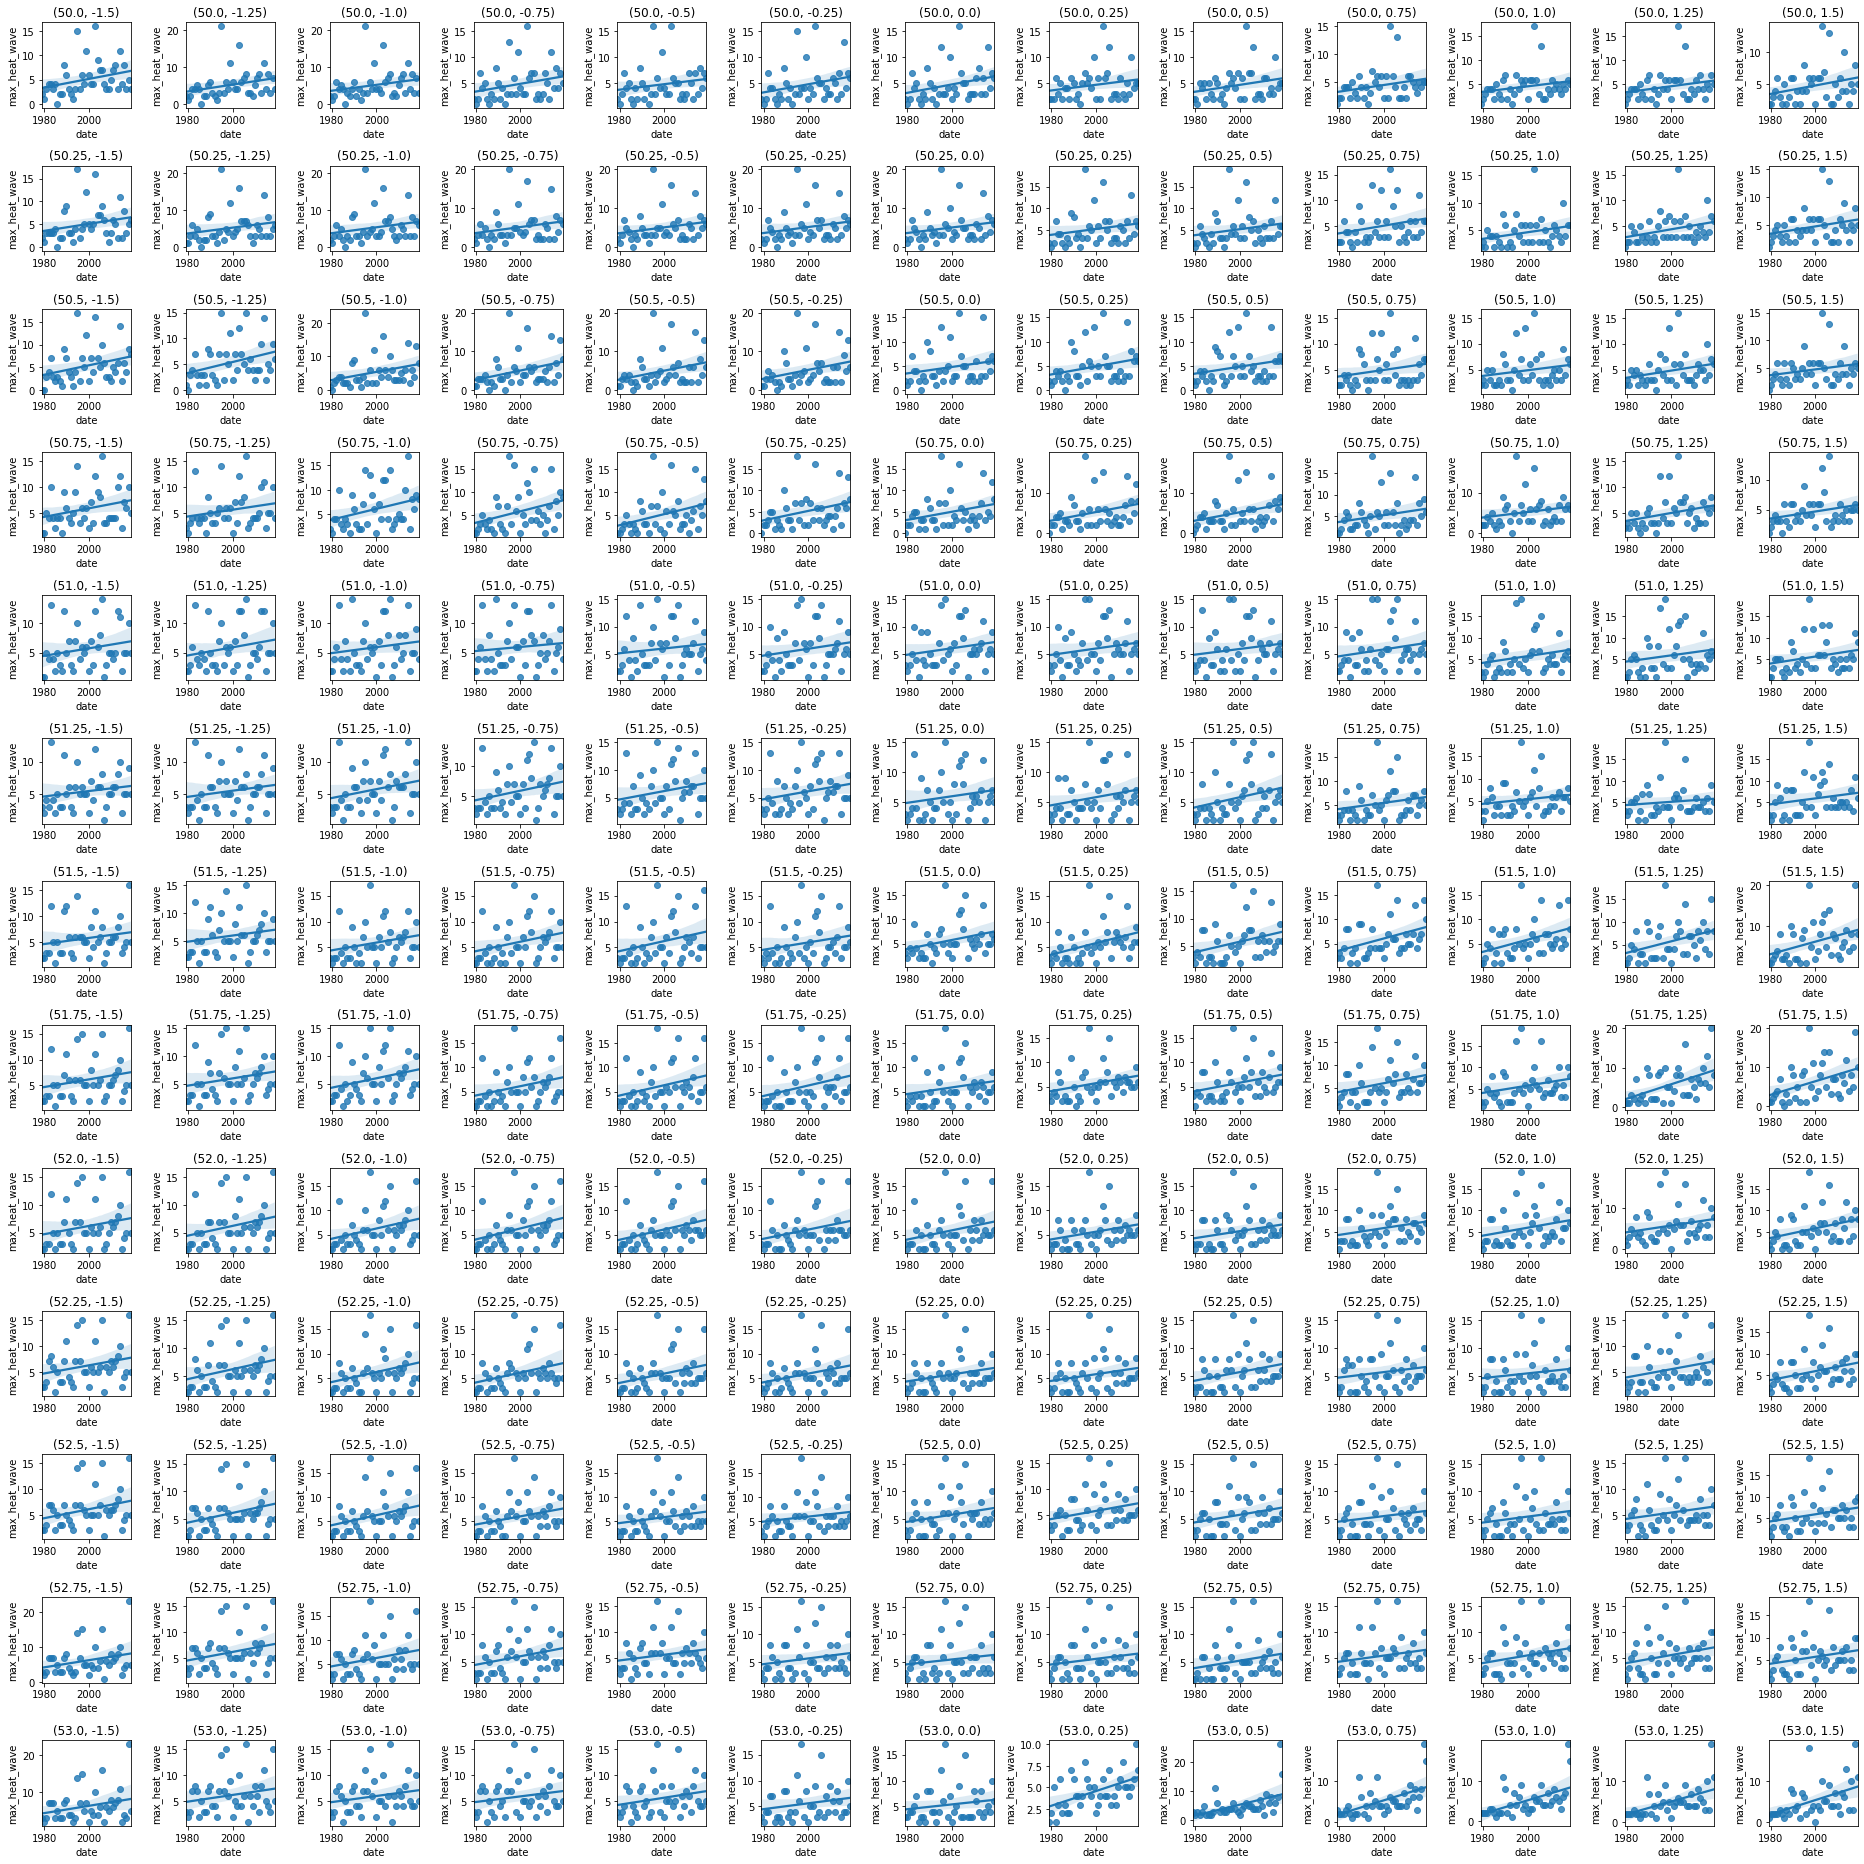

BIC 27103.52345111622


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          max_heat_wave   No. Observations:                 6929
Model:                            GLM   Df Residuals:                     6591
Model Family:                Gaussian   Df Model:                          337
Link Function:               identity   Scale:                          12.956
Method:                          IRLS   Log-Likelihood:                -18533.
Date:                Sun, 13 Jun 2021   Deviance:                       85391.
Time:                        20:38:22   Pearson chi2:                 8.54e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    -170.4732     94.972     -1.795      0.073    -356.614      15.668
C(coo)[T.(50.0, -1.25)]        -8.9815    134.310     -0.067      0.947    -272.225     254.262
C(coo)[T.(50.0, -1.0)]         17.0890    134.310      0.127      0.899    -246.154     280.332
C(coo)[T.(50.0, -0.75)]        25.8754    134.310      0.193      0.847    -237.368     289.119
C(coo)[T.(50.0, -0.5)]         69.3589    134.310      0.516      0.606    -193.885     332.602
C(coo)[T.(50.0, -0.25)]        18.8127    134.310      0.140      0.889    -244.431     282.056
C(coo)[T.(50.0, 0.0)]          13.2162    134.310      0.098      0.922    -250.027     276.460
C(coo)[T.(50.0, 0.25)]         66.1026    134.310      0.492      0.623    -197.141     329.346
C(coo)[T.(50.0, 0.5)]          43.0932    134.310      0.321      0.748    -220.150     306.337
C(coo)[T.(50.0, 0.75)]         55.0139    134.310      0.410      0.682    -208.229     318.257
C(coo)[T.(50.0, 1.0)]          63.9399    134.310      0.476      0.634    -199.304     327.183
C(coo)[T.(50.0, 1.25)]         52.8200    134.310      0.393      0.694    -210.423     316.063
C(coo)[T.(50.0, 1.5)]          45.7017    134.310      0.340      0.734    -217.542     308.945
C(coo)[T.(50.25, -1.5)]        22.5880    134.310      0.168      0.866    -240.655     285.831
C(coo)[T.(50.25, -1.25)]       19.6244    134.310      0.146      0.884    -243.619     282.868
C(coo)[T.(50.25, -1.0)]        16.9359    134.310      0.126      0.900    -246.308     280.179
C(coo)[T.(50.25, -0.75)]       21.9646    134.310      0.164      0.870    -241.279     285.208
C(coo)[T.(50.25, -0.5)]        26.7671    134.310      0.199      0.842    -236.476     290.010
C(coo)[T.(50.25, -0.25)]       22.3129    134.310      0.166      0.868    -240.931     285.556
C(coo)[T.(50.25, 0.0)]         33.3596    134.310      0.248      0.804    -229.884     296.603
C(coo)[T.(50.25, 0.25)]        41.1676    134.310      0.307      0.759    -222.076     304.411
C(coo)[T.(50.25, 0.5)]         37.6362    134.310      0.280      0.779    -225.607     300.880
C(coo)[T.(50.25, 0.75)]        28.9054    134.310      0.215      0.830    -234.338     292.149
C(coo)[T.(50.25, 1.0)]         57.0235    134.310      0.425      0.671    -206.220     320.267
C(coo)[T.(50.25, 1.25)]        25.7847    134.310      0.192      0.848    -237.459     289.028
C(coo)[T.(50.25, 1.5)]         44.8833    134.310      0.334      0.738    -218.360     308.127
C(coo)[T.(50.5, -1.5)]        -30.0057    134.310     -0.223      0.823    -293.249     233.238
C(coo)[T.(50.5, -1.25)]       -34.5331    134.310     -0.257      0.797    -297.777     228.710
C(coo)[T.(50.5, -1.0)]        -65.9007    134.310     -0.491      0.624    -329.144     197.343
C(coo)[T.(5

In [ ]:
#@title Baseline

# visualize

import seaborn as sns

locs = itertools.product(heat_wave.index.levels[0].to_list(),heat_wave.index.levels[1].to_list())
fig,axs = plt.subplots(13,13,figsize=(26,26))

for loc,ax in zip(locs,axs.ravel()):
  s = heat_wave.loc[loc]
  ax.set_title(loc)
  sns.regplot(x=s.index,y=s,ax=ax)

plt.tight_layout()
plt.show()

# goodness of fit

import statsmodels as sm
from statsmodels.formula import api 

df = heat_wave.reset_index()
df['coo'] = df.apply(lambda r: (r['lat'],r['long']),axis=1)
glm = api.glm('max_heat_wave~C(coo)+date:C(coo)',data=df)
glm = glm.fit()
print('BIC',glm.bic)
glm.summary()

In [ ]:
#@title Time and Spatial Effects

## add base categorical features
df_extended = df[['coo']]

## add and scale base continuous features
tmp = df[['lat','long','date','max_heat_wave']]
tmp['date'] = tmp['date'] - tmp['date'].min()
cols = ['lat','long','max_heat_wave']
tmp[cols] = tmp[cols]-tmp[cols].mean(0)
df_extended = df_extended.join(tmp)

## add periodic features (guess or look at the spectrum - the latter leaks some information)
from scipy import signal
lead_freqs = [1/2,1/3,1/4,1/5,1/6,1/7,1/8,1/9]
m = api.glm('max_heat_wave~date',data=df).fit()
resid = df['max_heat_wave']-m.fittedvalues
freqs, psd = signal.welch(resid)
lead_freqs = freqs[psd.argsort()[::-1]][:5]

for i,f in enumerate(lead_freqs,1):
  df_extended['sin%s'%i] = df['date'].map(lambda r: np.sin(2*np.pi*r*f))
  df_extended['cos%s'%i] = df['date'].map(lambda r: np.cos(2*np.pi*r*f))

## cross-interactions of coordinates
df_extended['lat:long'] = df_extended['lat']*df_extended['long']

## interactions of coordinates and periodic features
cols_group1 = filter(lambda c:'sin' in c or 'cos' in 'c',df_extended.columns)
cols_group2 = ['lat','long']
cols_prods = itertools.product(cols_group1,cols_group2)
cols_prods = map(lambda name: (df_extended[name[0]]*df_extended[name[1]]).rename(name[0]+':'+name[1]),cols_prods)
tmp = pd.concat(cols_prods,axis=1)
df_extended = df_extended.join(tmp)

## interactions of locations as factor
tmp = pd.get_dummies(df_extended['coo'])
tmp.columns = list(map(str,tmp.columns))
df_extended = df_extended.join(tmp)

## interactions of time and location as factor
tmp = pd.get_dummies(df_extended['coo']).multiply(df_extended['date'],axis=0)
tmp.columns = map(lambda s: 'date:'+str(s),tmp.columns)
df_extended = df_extended.join(tmp)

## scale features
#cols = df_extended.columns[df_extended.dtypes!='object']
#df_extended[cols] = df_extended[cols]/10

x_data = df_extended[list(filter(lambda c: ',' in c,df_extended.columns))]
y_data = df_extended['max_heat_wave']

## goodness of fit

glm = api.glm('max_heat_wave~1+(lat+long)*(sin1+cos1+sin2+cos2+sin3+cos3+sin4+cos4+sin5+cos5)+(lat+long)**2+date:C(coo)',data=df_extended)
glm = glm.fit()
print('BIC',glm.bic)
glm.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


BIC -2087.4651663481054


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          max_heat_wave   No. Observations:                 6929
Model:                            GLM   Df Residuals:                     6726
Model Family:                Gaussian   Df Model:                          202
Link Function:               identity   Scale:                          8.5331
Method:                          IRLS   Log-Likelihood:                -17157.
Date:                Sun, 13 Jun 2021   Deviance:                       57394.
Time:                        20:38:23   Pearson chi2:                 5.74e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.3923      0.071    -19.691      0.000      -1.531      -1.254
lat                             0.2627      0.076      3.476      0.001       0.115       0.411
long                           -0.2349      0.076     -3.108      0.002      -0.383      -0.087
sin1                           -3.9964      0.201    -19.917      0.000      -4.390      -3.603
cos1                            1.2072      0.211      5.726      0.000       0.794       1.620
sin2                            1.3661      0.049     28.021      0.000       1.271       1.462
cos2                           -0.0327      0.051     -0.642      0.521      -0.133       0.067
sin3                            3.4146      0.213     16.030      0.000       2.997       3.832
cos3                            2.0814      0.199     10.447      0.000       1.691       2.472
sin4                            0.5336      0.050     10.591      0.000       0.435       0.632
cos4                           -1.0686      0.049    -21.627      0.000      -1.165      -0.972
sin5                           -1.1091      0.057    -19.375      0.000      -1.221      -0.997
cos5                           -0.5410      0.060     -8.993      0.000      -0.659      -0.423
lat:sin1                       -0.2527      0.215     -1.178      0.239      -0.673       0.168
lat:cos1                       -0.4261      0.225     -1.891      0.059      -0.868       0.016
lat:sin2                       -0.0787      0.052     -1.510      0.131      -0.181       0.023
lat:cos2                       -0.1879      0.055     -3.448      0.001      -0.295      -0.081
lat:sin3                       -0.4194      0.228     -1.841      0.066      -0.866       0.027
lat:cos3                        0.0422      0.213      0.198      0.843      -0.375       0.460
lat:sin4                        0.2373      0.054      4.406      0.000       0.132       0.343
lat:cos4                        0.3426      0.053      6.486      0.000       0.239       0.446
lat:sin5                        0.0340      0.061      0.556      0.578      -0.086       0.154
lat:cos5                        0.1140      0.064      1.772      0.076      -0.012       0.240
long:sin1                       0.7136      0.215      3.327      0.001       0.293       1.134
long:cos1                      -0.0943      0.225     -0.418      0.676      -0.536       0.347
long:sin2                       0.0138      0.052      0.264      0.792      -0.088       0.116
long:cos2                      -0.1635      0.055     -2.999      0.003      -0.270      -0.057
long:sin3                      -0.3625      0.228     -1.592      0.111      -0.809       0.084
long:cos3                      -0.6323      0.213     -2.969      0.003      -1.050      -0.215
long:sin4  

### Robust Regression

We see that robust fitting makes the difference: we get somewhat smaller effects with more uncertainty (variance).

In [ ]:
glm = api.rlm('max_heat_wave~1+(lat+long)*(sin1+cos1+sin2+cos2+sin3+cos3+sin4+cos4+sin5+cos5)+date:C(coo)',data=df_extended)
glm = glm.fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          max_heat_wave   No. Observations:                 6929
Model:                            RLM   Df Residuals:                     6727
Method:                          IRLS   Df Model:                          201
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 13 Jun 2021                                         
Time:                        20:38:31                                         
No. Iterations:                    32                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.6161      0.054    -30.078      0.000      -1.721      -1.511
lat                             0.4310      0.057      7.504      0.000       0.318       0.544
long                           -0.1318      0.057     -2.294      0.022      -0.244      -0.019
sin1                           -3.8271      0.152    -25.100      0.000      -4.126      -3.528
cos1                            1.8053      0.160     11.269      0.000       1.491       2.119
sin2                            1.0383      0.037     28.027      0.000       0.966       1.111
cos2                            0.0744      0.039      1.921      0.055      -0.002       0.150
sin3                            3.9617      0.162     24.474      0.000       3.644       4.279
cos3                            1.9501      0.151     12.881      0.000       1.653       2.247
sin4                            0.4814      0.038     12.573      0.000       0.406       0.556
cos4                           -0.9689      0.038    -25.807      0.000      -1.043      -0.895
sin5                           -1.0163      0.043    -23.364      0.000      -1.102      -0.931
cos5                           -0.7625      0.046    -16.679      0.000      -0.852      -0.673
lat:sin1                       -0.5283      0.163     -3.241      0.001      -0.848      -0.209
lat:cos1                        0.6700      0.171      3.912      0.000       0.334       1.006
lat:sin2                       -0.0094      0.040     -0.239      0.811      -0.087       0.068
lat:cos2                       -0.1312      0.041     -3.167      0.002      -0.212      -0.050
lat:sin3                        0.8509      0.173      4.917      0.000       0.512       1.190
lat:cos3                        0.1006      0.162      0.622      0.534      -0.217       0.418
lat:sin4                        0.2297      0.041      5.611      0.000       0.149       0.310
lat:cos4                        0.2176      0.040      5.422      0.000       0.139       0.296
lat:sin5                       -0.0957      0.047     -2.058      0.040      -0.187      -0.005
lat:cos5                       -0.1598      0.049     -3.270      0.001      -0.256      -0.064
long:sin1                       0.3415      0.163      2.095      0.036       0.022       0.661
long:cos1                      -0.2613      0.171     -1.525      0.127      -0.597       0.074
long:sin2                      -0.0540      0.040     -1.362      0.173      -0.132       0.024
long:cos2                      -0.0912      0.041     -2.201      0.028      -0.172      -0.010
long:sin3                      -0.2937      0.173     -1.697      0.090      -0.633       0.045
long:cos3                      -0.2093      0.162     -1.293      0.196      -0.527       0.108
long:sin4  

### Fully Bayesian Inference

Note that exact MCMC sampling is inefficient here, so we use variational approximation.

In [ ]:
## prepare the data

x_cols = []
x_cols += list(filter(lambda c: 'sin' in c or 'cos' in c or 'lat' in c or 'long' in c, df_extended.columns))
x_cols += filter(lambda c: 'date:' in c, df_extended.columns)

x = df_extended[x_cols]
x_region = pd.get_dummies(df_extended['coo'])
y = df_extended['max_heat_wave']

In [ ]:
import pymc3 as pm

## define the model

with pm.Model() as bayes_model:
  x = pm.Data('x',x)
  x_region = pm.Data('x_region',x_region)
  y = pm.Data('y',y)
  sigma = pm.HalfNormal('sigma',10.0)
  # b0 = pm.Normal('b0',mu=0,sigma=10.0) # use for random intercept
  b0 = 0
  b_offset = pm.Normal('b_offset',mu = 0,sigma=10.0)
  b = pm.Deterministic('b',b0+b_offset)
  #w0 = pm.Normal('w0',mu=0,sigma=10.0) # use for random slope
  w0 = 0
  w_offset = pm.Normal('w_offset',mu=0,sigma=10.0,shape=(x.shape.eval()[1], ))
  w = pm.Deterministic('w',w0+w_offset)
  y_pred = pm.math.matrix_dot(x,w)+ b # pm.math.matrix_dot(x_region,b)
  out = pm.StudentT('y_pred',mu = y_pred,sigma=sigma,nu=1,observed=y) 

## sample (approximate posterior!)
with bayes_model:
  approx = pm.fit(n=30000, method='ADVI')
trace = approx.sample(1000)

## readable summary
summary = pm.summary(trace,var_names=['w'])
names_dict = dict(zip(list(map(lambda c:'w[%s]'%c,range(len(x_cols)))),x_cols))
summary.index = summary.index.map(names_dict.get)
summary

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 17,897
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lat,0.502,0.023,0.459,0.546,0.001,0.001,929.0,880.0,NaN
long,-0.048,0.024,-0.093,-0.005,0.001,0.001,1031.0,865.0,NaN
sin1,-2.711,0.033,-2.775,-2.650,0.001,0.001,902.0,878.0,NaN
cos1,1.044,0.030,0.990,1.100,0.001,0.001,877.0,951.0,NaN
sin2,0.807,0.031,0.743,0.858,0.001,0.001,902.0,941.0,NaN
cos2,0.165,0.031,0.108,0.222,0.001,0.001,745.0,972.0,NaN
sin3,2.929,0.033,2.870,2.988,0.001,0.001,985.0,983.0,NaN
cos3,1.221,0.029,1.167,1.274,0.001,0.001,751.0,709.0,NaN
sin4,0.352,0.029,0.301,0.409,0.001,0.001,999.0,948.0,NaN
cos4,-0.694,0.030,-0.748,-0.634,0.001,0.001,1113.0,1015.0,NaN


### Trend Testing

What are the chances that the slope of the time trend is 

* at least 0.05 (the slope from robust model heat_wave ~ time) at a random location?
* at least 0.1 (the pesymistic slope bound) at the last 80 locations?

Given that the model is simplistic, high-confidence should be expected before claiming the effect.

In [ ]:
## composite (!) hypothesis testing using bayesian posterior

np.random.seed(123)

idxs = np.random.randint(0,169,1)

test1 = (trace.get_values('w')[:,idxs]>0.05).mean()
test2 = (trace.get_values('w')[:,-80:]>0.1).max(1).mean()
print(test1,test2)

0.963 0.934


### Forecasting

The foreast with new observations available can be made via [posterior predictive](https://en.wikipedia.org/wiki/Posterior_predictive_distribution).

### Gaussian Process

We will use Tensorflow and GPFlow; for simplicity we consider the separable temporal/spatial covriance, made of the product of the spatial kernel (here: combination of linear and Matern) and the temporal kernel (here: combination of linear, RBF and periodic kernels). The fast sparse approximation makes fitting very efficient. For the sake of illustration, we add one extra data point which at (51.5, 0)  has a heatwave of length 10 days in the year 2050.

In [ ]:
#@title Install GPFlow

!pip -q install gpflow

import tensorflow as tf
import gpflow

In [ ]:
#@title Prepare Data

## need to scale data for gradient-based optimization !

X_t = df[['lat','long','date']]
X_t= X_t.append({'lat':51.5,'long':0,'date':2050},ignore_index=True)
X_shift = X_t.mean(0)
print('shifting x:',X_shift)
X_t = X_t-X_shift
X_t = X_t.values/10.0
y_t = df[['max_heat_wave']]
y_t = y_t.append({'max_heat_wave':10},ignore_index=True)
y_shift = y_t.mean(0)
print('shifting y',y_shift)
y_t = y_t-y_shift
y_t = y_t.values/10.0

shifting x: lat       51.500000
long       0.000000
date    1999.007359
dtype: float64
shifting y max_heat_wave    5.513997
dtype: float64


In [ ]:
#@title Train GP Process
N_SAMPLES = X_t.shape[0]
N_SUBSAMPLES = 300
subsample_idx = np.random.randint(N_SAMPLES,size=N_SUBSAMPLES)
subsample_idx = list(subsample_idx)
subsample_idx.append(N_SAMPLES-1) 

kernel_spatial = gpflow.kernels.Matern32(active_dims=[0,1])

kernel_time1 = gpflow.kernels.Linear(active_dims=[2])
kernel_time2 = gpflow.kernels.RBF(active_dims=[2], lengthscales=10.0)
kernel_time3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(active_dims=[2]), period=[2/10])
kernel_time4 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(active_dims=[2]), period=[10/10])
kernel_time = kernel_time1 + kernel_time2 + kernel_time3 + kernel_time4

kernel = kernel_spatial * kernel_time
model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), X_t[subsample_idx], num_data=N_SAMPLES)

gpflow.set_trainable(model.inducing_variable, False)

data = tf.data.Dataset.from_tensor_slices((X_t,y_t))
data = data.repeat(100).shuffle(100).batch(100)

def optimize(model, N_ITER=100):

  logf = []
  train_iter = iter(data)
  training_loss = model.training_loss_closure(train_iter, compile=True)
  optimizer = tf.optimizers.Adam()

  @tf.function
  def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)

  for step in range(N_ITER):
      optimization_step()
      if step % 10 == 0:
          elbo = -training_loss().numpy()
          print(elbo)
          logf.append(elbo)
  return logf

optimize(model,1000)

-21715.298000035058
-20599.888562346554
-20011.645436320734
-19074.91205022168
-17766.729111150828
-17837.85441943212
-17431.784906647863
-16104.868082394622
-16023.513401629349
-15144.92831638436
-14936.753346930216
-14529.283050061174
-13953.539310141769
-12906.94639867113
-12837.414127445822
-12488.708678155976
-12413.992796960394
-12281.356195621946
-11836.372933362285
-10912.088768573847
-10776.911873513027
-10729.38385920362
-10968.36868199268
-10739.284212091981
-10511.936276778171
-10450.282606976425
-9964.839565892793
-9658.543896357265
-9582.542508893768
-9780.655686452084
-9847.902054785009
-9944.233512493276
-8809.954588815324
-8831.40476717962
-8780.33176457838
-8851.491139743128
-8819.134642009996
-8881.73826220735
-8241.218773893997
-8509.607005516149
-8717.911686973024
-8594.863387944804
-8691.094643017226
-8989.468960899858
-8195.305821448532
-8079.278936721187
-7910.8432052198295
-8043.832574541209
-8106.143136911848
-8306.494299252712
-8173.538249045475
-7682.8327802

[-21715.298000035058,
 -20599.888562346554,
 -20011.645436320734,
 -19074.91205022168,
 -17766.729111150828,
 -17837.85441943212,
 -17431.784906647863,
 -16104.868082394622,
 -16023.513401629349,
 -15144.92831638436,
 -14936.753346930216,
 -14529.283050061174,
 -13953.539310141769,
 -12906.94639867113,
 -12837.414127445822,
 -12488.708678155976,
 -12413.992796960394,
 -12281.356195621946,
 -11836.372933362285,
 -10912.088768573847,
 -10776.911873513027,
 -10729.38385920362,
 -10968.36868199268,
 -10739.284212091981,
 -10511.936276778171,
 -10450.282606976425,
 -9964.839565892793,
 -9658.543896357265,
 -9582.542508893768,
 -9780.655686452084,
 -9847.902054785009,
 -9944.233512493276,
 -8809.954588815324,
 -8831.40476717962,
 -8780.33176457838,
 -8851.491139743128,
 -8819.134642009996,
 -8881.73826220735,
 -8241.218773893997,
 -8509.607005516149,
 -8717.911686973024,
 -8594.863387944804,
 -8691.094643017226,
 -8989.468960899858,
 -8195.305821448532,
 -8079.278936721187,
 -7910.8432052198

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


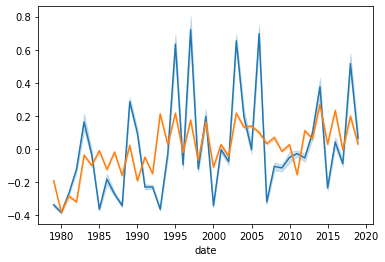

In [ ]:
#@title Visualize
sns.lineplot(df['date'],y_t.ravel()[:-1])
sns.lineplot(df['date'],model.predict_y(X_t[:-1,:])[0].numpy().ravel())

In [ ]:
#@title Forecasting
## remember to scale input !

lat = 51.75 #@param 
long = -1.25 #@param
year = 2050 #@param

out = model.predict_y((np.array([[lat,long,year]])-X_shift.values)/10.0)
val,err = out[0].numpy(),out[1].numpy()
## remember to scale output
val = val + y_shift.values
print('Estimated val=%s Std=%s'%(val,err))

Estimated val=[[6.0504789]] Std=[[1.21020133]]


## Extra Notes

In [ ]:
# robust fit with time and spatial effects

glm = api.rlm('max_heat_wave~1+lat+long+date',data=df)
glm = glm.fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          max_heat_wave   No. Observations:                 6929
Model:                            RLM   Df Residuals:                     6925
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 10 Jun 2021                                         
Time:                        14:34:09                                         
No. Iterations:                    24                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -159.7123      5.828    -27.404      0.000    -171.135    -148.290
lat            0.3075      0.035      8.769      0.000       0.239       0.376
long          -0.1568      0.035     -4.473      0.000      -0.226      -0.088
date           0.0744      0.003     26.858      0.000       0.069       0.080
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

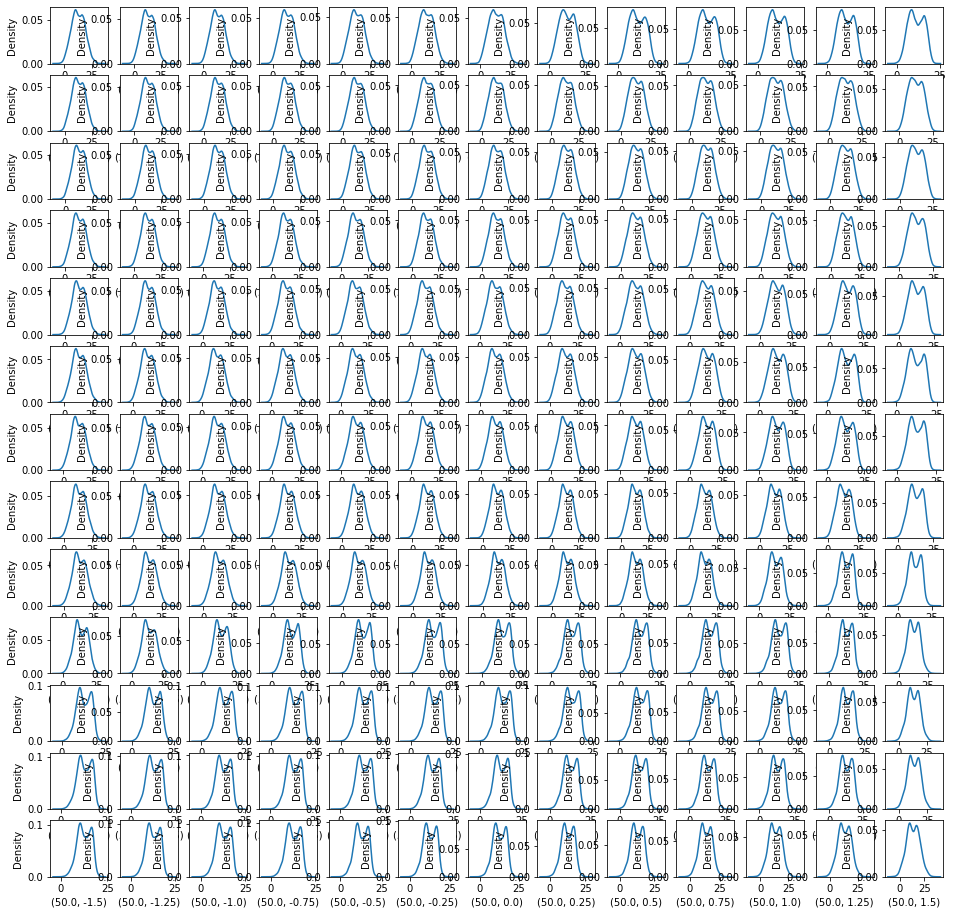

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

fig,axs=plt.subplots(13,13,figsize=(16,16))
for series,ax in zip([df[c] for c in df.columns],axs.ravel()):
  sns.kdeplot(series,ax=ax)
plt.show()
#sns.kdeplot(df.loc[:,51.25,0.0])

In [ ]:
# model
jds_ab = tfp.distributions.JointDistributionNamedAutoBatched(dict(

    sigma=tfp.distributions.HalfNormal(scale=1.0),

    alpha=tfp.distributions.Normal(loc=0.0,scale=10.0),

    beta=tfp.distributions.Normal(loc=np.zeros(N_FEATURES,np.float32),
                                  scale=10.0*np.ones(N_FEATURES,np.float32)),

    y=lambda beta, alpha, sigma: tfp.distributions.Normal(
            loc=tf.linalg.matvec(x_t,beta) + alpha, 
            scale=sigma)
))

# logp
def logp(beta=beta, alpha=alpha, sigma=sigma):
    return jds_ab.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y_t)

# mcmc sampling

N_CHAIN_SAMPLES = int(1e3)
N_BURN = int(1e4)

nuts_kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=logp,step_size=1.0)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel = nuts_kernel,
                                                 num_adaptation_steps=int(N_BURN * 0.8))

@tf.function
def run_chain():
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=N_CHAIN_SAMPLES,
      num_burnin_steps=N_BURN,
      current_state=[
          tf.convert_to_tensor(np.ones(N_FEATURES), dtype=tf.float32),
          tf.convert_to_tensor(1.0, dtype=tf.float32), 
          tf.convert_to_tensor(1.0, dtype=tf.float32)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples